In [ ]:
from typing import Optional
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
from sympy.physics.units import velocity


# Define the RL environment
class ColorMatchEnv(gym.Env):
    def __init__(self):
        super(ColorMatchEnv, self).__init__()
        # self.target_color = np.random.rand(3)  # Random target RGB
        # self.current_color = np.random.rand(3)  # Start with random color
        
        self.velocity = 0
        self.difference = 0
    
        # Action space: Increase or decrease R, G, B
        self.action_space = spaces.Discrete(6)  
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)

    def step(self, action):
        
        prev_color = self.current_color.copy()
        
        step_size = 0.02
        if action == 0: self.current_color[0] += step_size  # Increase R
        elif action == 1: self.current_color[0] -= step_size  # Decrease R
        elif action == 2: self.current_color[1] += step_size  # Increase G
        elif action == 3: self.current_color[1] -= step_size  # Decrease G
        elif action == 4: self.current_color[2] += step_size  # Increase B
        elif action == 5: self.current_color[2] -= step_size  # Decrease B

        # Clamp values between 0 and 1
        self.current_color = np.clip(self.current_color, 0, 1)
        
        # velocity = self.current_color - prev_color
        # direction = self.target_color - self.current_color
        # reward = np.sign(np.dot(velocity, direction)) 
        # reward = np.sign(np.dot(velocity, direction)) 
        
        
        # Compute reward (negative Euclidean distance)
        #max_distance = np.linalg.norm(np.array([1, 1, 1]))
        # reward = -np.linalg.norm(self.current_color - self.target_color) #/ max_distance
        
        
        # reward = 1 - np.linalg.norm(self.target_color - self.current_color) #/ max_distance
        # reward = pow(reward, 2)
        
        # reward = self.velocity_reward(self.current_color, self.target_color, self.current_color - prev_color)
        
        # reward = -np.sum(np.abs(self.current_color - self.target_color)) / max_distance
        
        
        # cosine_similarity = np.dot(self.current_color, self.target_color) / (np.linalg.norm(self.current_color) * np.linalg.norm(self.target_color))
        # reward = (1 - cosine_similarity) / max_distance
        
        velocity = self.current_color - prev_color
        self.velocity = np.sign(self.velocity_reward(self.current_color, self.target_color, self.current_color - prev_color))
        
        if np.linalg.norm(velocity) < 0.01 or self.velocity < 0:
            reward = -1
        else:
            self.difference = 1 - np.linalg.norm(self.current_color - self.target_color)
            reward = pow(self.difference, 2) + self.velocity * 0.5
            # reward = pow(reward, 2) # min(1, reward)
        
        # reward = self.velocity_reward(self.current_color, self.target_color, self.current_color - prev_color)
        # reward = self.smooth_reward(self.current_color, self.target_color, self.current_color - prev_color)
        
        # Done if very close to target
        done = np.linalg.norm(self.current_color - self.target_color) < 0.01
        truncated = False
        observation = self._get_obs()
        info = self._get_info()
    
        return observation, reward, done.all(), truncated, info
    
    def velocity_reward(self, agent_position, target_position, agent_velocity):
        direction_to_target = target_position - agent_position
        direction_to_target /= np.linalg.norm(direction_to_target)  # Normalize direction
        velocity_dot_product = np.dot(agent_velocity, direction_to_target)
        return velocity_dot_product
    
    def smooth_reward(self, agent_position, target_position, agent_velocity, lambda_factor=1):
        # distance = np.linalg.norm(agent_position - target_position)
        distance = 1 - np.linalg.norm(self.target_color - self.current_color)
        distance = pow(distance, 2)
        direction_to_target = target_position - agent_position
        direction_to_target /= np.linalg.norm(direction_to_target)  # Normalize direction
        velocity_dot_product = np.dot(agent_velocity, direction_to_target)
        
        return distance + lambda_factor * velocity_dot_product

    def _get_obs(self):
        return np.concatenate([self.current_color, self.target_color])
    
    def _get_info(self):
        return { "distance" : np.linalg.norm(self.current_color - self.target_color), "velocity" : self.velocity, "difference" : self.difference}
    
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.target_color = self.np_random.uniform(0, 1, size=3)  # New target
        self.current_color = self.np_random.uniform(0, 1, size=3)  # Reset color

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

log_dir = "./ppo_logs/"
new_logger = configure(log_dir, ["csv", "tensorboard"])

# Train with PPO
env = ColorMatchEnv()
env = Monitor(env, log_dir)
model = PPO("MlpPolicy", env, verbose=1, clip_range=0.2, ent_coef=0.0, learning_rate=0.0005)
model.set_logger(new_logger)
model.learn(total_timesteps=50000)


Using cpu device
Wrapping the env in a DummyVecEnv.


Index(['time/time_elapsed', 'time/fps', 'time/total_timesteps',
       'time/iterations', 'train/clip_range', 'train/value_loss',
       'train/n_updates', 'train/loss', 'train/policy_gradient_loss',
       'train/explained_variance', 'train/clip_fraction',
       'train/learning_rate', 'train/approx_kl', 'train/entropy_loss',
       'rollout/ep_len_mean', 'rollout/ep_rew_mean'],
      dtype='object')


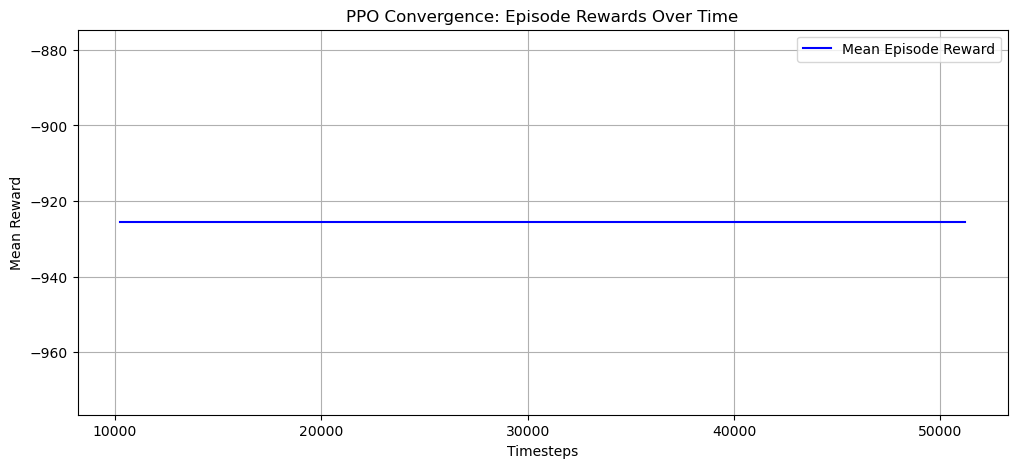

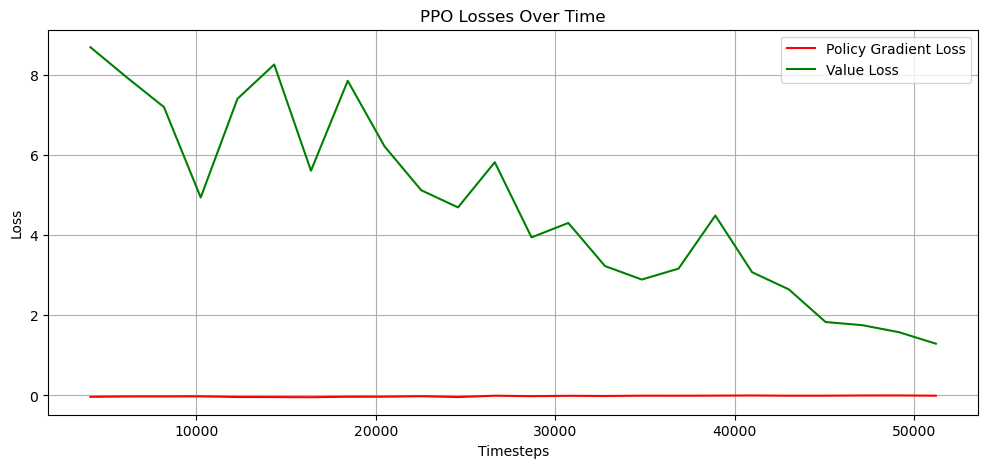

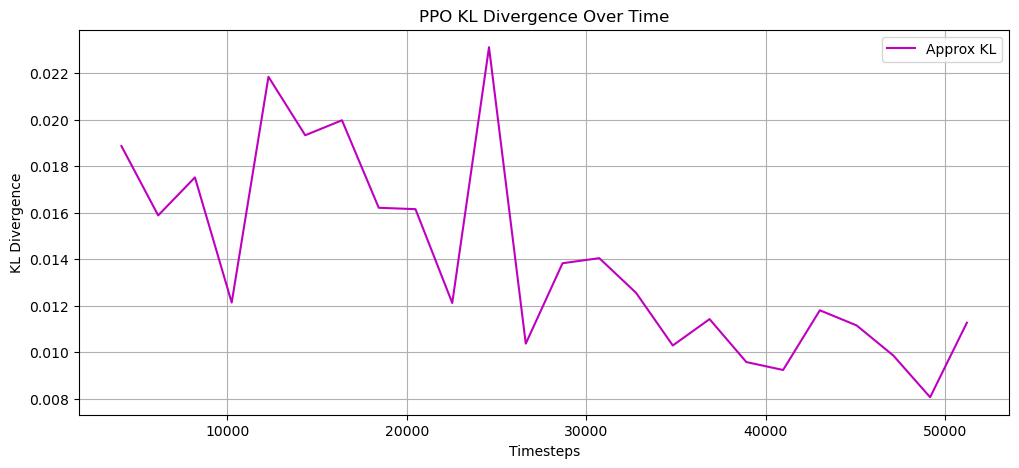

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load PPO logs
log_file = "./ppo_logs/progress.csv"  # Make sure this path matches your logger output
data = pd.read_csv(log_file)
print(data.columns)

# Plot Episode Rewards
plt.figure(figsize=(12, 5))
plt.plot(data["time/total_timesteps"], data["rollout/ep_rew_mean"], label="Mean Episode Reward", color='b')
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("PPO Convergence: Episode Rewards Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot Losses (Policy Gradient Loss & Value Loss)
plt.figure(figsize=(12, 5))
plt.plot(data["time/total_timesteps"], data["train/policy_gradient_loss"], label="Policy Gradient Loss", color='r')
plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss", color='g')
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("PPO Losses Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot KL Divergence (to check stability)
plt.figure(figsize=(12, 5))
plt.plot(data["time/total_timesteps"], data["train/approx_kl"], label="Approx KL", color='m')
plt.xlabel("Timesteps")
plt.ylabel("KL Divergence")
plt.title("PPO KL Divergence Over Time")
plt.legend()
plt.grid()
plt.show()


In [35]:

# Test the trained agent
obs, _ = env.reset()
done = False
count = 0
while not done:
    count+=1
    action, _ = model.predict(obs)
    obs, reward, done, _, infos = env.step(action)
    direction = obs[3:] - obs[:3]
    # print(f"Color: {obs[:3]}, Target: {obs[3:]}, {action} Reward: {reward}")
    print(f"Reward: {round(reward, 2)} Velocity: {round(infos['velocity'], 2)} Difference: {round(infos['difference'], 2)}")

print(f"Done in {count} steps")

Reward: 0.9 Velocity: 1.0 Difference: 0.4
Reward: 0.91 Velocity: 1.0 Difference: 0.41
Reward: 0.92 Velocity: 1.0 Difference: 0.42
Reward: 0.93 Velocity: 1.0 Difference: 0.43
Reward: 0.94 Velocity: 1.0 Difference: 0.44
Reward: 0.95 Velocity: 1.0 Difference: 0.45
Reward: 0.95 Velocity: 1.0 Difference: 0.45
Reward: 0.96 Velocity: 1.0 Difference: 0.46
Reward: 0.96 Velocity: 1.0 Difference: 0.46
Reward: 0.97 Velocity: 1.0 Difference: 0.47
Reward: 0.98 Velocity: 1.0 Difference: 0.48
Reward: -1 Velocity: -1.0 Difference: 0.48
Reward: 0.98 Velocity: 1.0 Difference: 0.48
Reward: 0.99 Velocity: 1.0 Difference: 0.49
Reward: 1 Velocity: 1.0 Difference: 0.51
Reward: 1 Velocity: 1.0 Difference: 0.52
Reward: 1 Velocity: 1.0 Difference: 0.52
Reward: 1 Velocity: 1.0 Difference: 0.53
Reward: -1 Velocity: -1.0 Difference: 0.53
Reward: 1 Velocity: 1.0 Difference: 0.53
Reward: 1 Velocity: 1.0 Difference: 0.53
Reward: 1 Velocity: 1.0 Difference: 0.54
Reward: 1 Velocity: 1.0 Difference: 0.54
Reward: 1 Veloci

KeyboardInterrupt: 